In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# Read Data set

In [ ]:
train_path = "/content/optdigits.tra" 
df_train = pd.read_csv(train_path, header=None)

test_path = "/content/optdigits.tes"
df_test = pd.read_csv(test_path, header = None)


In [ ]:
X_train = df_train[np.arange(64)] #Train Data without class label
Y_train = df_train[64] #Class Label

In [ ]:
X_test = df_test[np.arange(64)] #Test Data without class label
Y_test = df_test[64] #Class Label

#Standardization of the data set

In [ ]:
X_train = (X_train - np.mean(X_train)) / (np.std(X_train) + 1e-8)
X_test =  (X_test - np.mean(X_test)) / (np.std(X_test) + 1e-8)

# One hot encoding Class labels

In [ ]:
y_train = np.zeros((Y_train.size, int(Y_train.max()) + 1))
y_train[np.arange(Y_train.size),Y_train.astype(np.int)] = 1.0

y_test = np.zeros((Y_test.size, int(Y_test.max()) + 1))
y_test[np.arange(Y_test.size),Y_test.astype(np.int)] = 1.0

# Tanh Activation Function

In [ ]:
def tanh_activation(x):
  return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

# Cross Entropy Loss Function

In [ ]:
def cross_entropy_loss(y_actual,y_pred):
  m = y_actual.shape[1]
  cross_entropy_loss = -1/m * (np.sum(np.multiply(y_actual,np.log(y_pred)) 
                      + np.multiply((1 - y_actual), np.log(1 - y_pred))))
  return np.squeeze(cross_entropy_loss)

# Softmax Function

In [ ]:
def softmax(s):
  exps = np.exp(s - np.max(s))
  return exps/np.sum(exps,axis=0,keepdims=True)

#Initialize First Parameters

In [ ]:
def initialize_parameters(n_input_units,n_hidden_units,n_output_units):
  np.random.seed(1)

  #Hidden layer weights and bias
  W_hid = np.random.randn(n_hidden_units, n_input_units)* 0.01
  b_hid = np.zeros((n_hidden_units,1)) 

  #Output layer weights and bias
  W_out = np.random.randn(n_output_units, n_hidden_units)* 0.01 
  b_out = np.zeros((n_output_units,1))

  parameters = {"W_hid" : W_hid,
                        "b_hid" : b_hid,
                        "W_out" : W_out,
                        "b_out" : b_out}

  return parameters

# Forward Propagation

In [ ]:
def forward_propagation(X_train,parameters):

    hidden_val = np.dot(parameters["W_hid"],X_train) + parameters["b_hid"]
    hidden_activation = tanh_activation(hidden_val)

    output_val = np.dot(parameters["W_out"],hidden_activation)+ parameters["b_out"]
    output_softmax = softmax(output_val)



    save_vals = {'hidden_val': hidden_val,
                 'hidden_activation': hidden_activation,
                 'output_val': output_val,
                 'output_softmax': output_softmax}
    
    return output_softmax , save_vals

# Backward Propagation

In [ ]:
def backward_propagation(X_train,y_train,parameters,forward_save_parameters,batch_size):
    m = X_train.shape[1]
    
    output = forward_save_parameters["output_softmax"]- y_train
    deriv_output_w = np.dot(output, forward_save_parameters["hidden_activation"].T)/batch_size
    deriv_output_b = np.sum(output, axis=1, keepdims=True) / batch_size

    deriv_hidden = np.dot(parameters["W_out"].T, output) * (1 - np.power(forward_save_parameters["hidden_val"], 2))
    deriv_hidden_w = np.dot(deriv_hidden, X_train.T) /batch_size
    deriv_hidden_b = np.sum(deriv_hidden, axis=1, keepdims=True) / batch_size

    gradients = {'deriv_hidden_w': deriv_hidden_w,
                 'deriv_hidden_b': deriv_hidden_b,
                 'deriv_output_w': deriv_output_w,
                 'deriv_output_b': deriv_output_b}
    
    return gradients

# Update Parameters

In [ ]:
def update_parameters(parameters, gradients, learning_rate = 0.001):

    W_hid = parameters["W_hid"] - learning_rate * gradients["deriv_hidden_w"]
    b_hid = parameters["b_hid"] - learning_rate * gradients["deriv_hidden_b"]
    W_out = parameters["W_out"] - learning_rate * gradients["deriv_output_w"]
    b_out = parameters["b_out"] - learning_rate * gradients["deriv_output_b"]

    update_parameters = {"W_hid" : W_hid,
                        "b_hid" : b_hid,
                        "W_out" : W_out,
                        "b_out" : b_out}
    
    return update_parameters

# Create Mini-Batchs

In [ ]:
def create_batchs(X_train,y_train,batch_size):
    batch_x = []
    batch_y = []

    len_data = len(X_train)
    for i in range(0, len_data, batch_size):
        if i + batch_size <= len_data:
            batch_x.append(X_train[i:i+batch_size])
            batch_y.append(y_train[i:i+batch_size])
        else:
            batch_x.append(X_train[i:])
            batch_y.append(y_train[i:])
    return batch_x,batch_y

# Calculate Accuracy

In [ ]:
def accuracy(y_pred, y_train):  
  return np.all(y_pred == y_train, axis=1).mean()

# Transform output values to categorical 




In [ ]:
def to_categorical(x):  
    # Transform probabilities into categorical predictions row-wise, by simply taking the max probability
    categorical = np.zeros((x.shape[0],x.shape[1]))
    categorical[np.arange(x.shape[0]),x.argmax(axis=1)] = 1
    return categorical

# Train Data with multiple epochs and using mini-batch

In [ ]:
def MLP_train(X_train, y_train, n_input_unit, n_hidden_unit,n_output_unit,batch_size,epochs = 300):

  parameters = initialize_parameters(n_input_unit, n_hidden_unit, n_output_unit)
  batch_X, batch_Y = create_batchs(X_train,y_train,batch_size)
  
  for epoch in range(epochs):
    cost = 0
    train_acc = 0
    for batch_x, batch_y in zip(batch_X,batch_Y):

      output_softmax , save_vals = forward_propagation(batch_x.T, parameters) #Feed forward
      cost += cross_entropy_loss(batch_y.T,output_softmax + 1e-10) #Calculate loss
      train_acc += accuracy(to_categorical(output_softmax.T),batch_y) #Calculate Accuracy
      gradients = backward_propagation(batch_x.T,batch_y.T,parameters,save_vals,batch_size) #Backward
      
      parameters = update_parameters(parameters, gradients) #Update parameters
    
    cost = (cost/len(batch_X))
    train_acc = (train_acc/len(batch_X))
    print(f"Epoch {epoch+1}: loss = {cost} | acc = {train_acc}")
    
  return parameters

# Learn parameters on train dataset

- Number of Input Units: 64
- Number of Hidden Layer: 1
- Number of Hidden Layer Units: 64
- Number of Output Units: 10
- Batch Size: 64
- Epoch : 300
 

In [ ]:
parameters = MLP_train(X_train, y_train, 64, 64,10,64)

Epoch 1: loss = 3.2489090885508793 | acc = 0.12227393617021276
Epoch 2: loss = 3.2471791320224783 | acc = 0.17175310283687942
Epoch 3: loss = 3.2454330075595976 | acc = 0.24177748226950355
Epoch 4: loss = 3.243662392679798 | acc = 0.3264350620567376
Epoch 5: loss = 3.2418588660060355 | acc = 0.416938164893617
Epoch 6: loss = 3.2400138657565787 | acc = 0.49882535460992905
Epoch 7: loss = 3.238118648807417 | acc = 0.5628158244680851
Epoch 8: loss = 3.2361642502983523 | acc = 0.6136912677304964
Epoch 9: loss = 3.234141443791368 | acc = 0.6551196808510638
Epoch 10: loss = 3.2320407020310475 | acc = 0.6812555407801419
Epoch 11: loss = 3.2298521584024216 | acc = 0.7082668439716312
Epoch 12: loss = 3.227565569231944 | acc = 0.7267564273049646
Epoch 13: loss = 3.2251702771329422 | acc = 0.7350897606382979
Epoch 14: loss = 3.222655175657863 | acc = 0.7443705673758866
Epoch 15: loss = 3.220008675586229 | acc = 0.7487976507092199
Epoch 16: loss = 3.2172186732494423 | acc = 0.7527039007092199
Epoc

# Prediction on Test Data set using 
Using parameters that learned from train data.

In [ ]:
def predict(X_test,y_test,parameters):
    y_pred, _ = forward_propagation(X_test, parameters) # Find class labels
    test_acc = accuracy(to_categorical(y_pred.T),y_test) # Calculate test accuracy
    print(f'Test accuracy : {test_acc}')
    return to_categorical(y_pred.T)

# Test Accuracy 

In [ ]:
y_pred = predict(X_test.T,y_test,parameters)

Test accuracy : 0.9198664440734557


# Plot Confusion Matrix

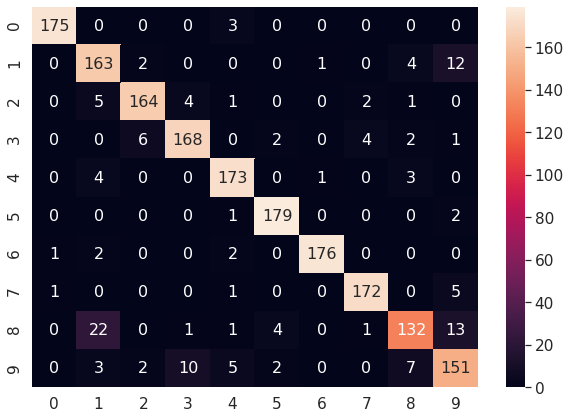

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


confusion_mat_arr = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)) #Create a confusion matrix array
confusion_mat_data = pd.DataFrame(confusion_mat_arr, columns=np.unique(y_pred.argmax(axis=1)), index = np.unique(y_pred.argmax(axis=1))) #Convert array to dataframe


#Plotting Confusion matrix
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #label size
sns.heatmap(confusion_mat_data, annot=True,annot_kws={"size": 16},fmt='g')

plt.show()